# AdSnap: AI-Powered Ad Banner Generator  


In [1083]:
import random  # For selecting random samples
import matplotlib.pyplot as plt


from IPython.display import display

from PIL import Image, ImageDraw, ImageFont
import numpy as np
import random


import ast
import matplotlib.pyplot as plt
import random

## Setup for OpenAI API

In [485]:
!pip install openai python-dotenv


In [522]:
import os

 ## Load Environment Variables

 For security purposes, we are not hardcoding the API key.
 For reproducibility of code, please replace below key.

In [1024]:
from dotenv import load_dotenv

# Loads the env file to get the environment variables
load_dotenv()

# Get the OpenAI API key
open_ai_api_key = os.getenv("OPENAI_API_KEY")

# Print to check if the API key is loaded
print("✅ API key loaded:", open_ai_api_key[:8] + "..." if open_ai_api_key else "❌ Not found")


✅ API key loaded: sk-proj-...


In [1026]:
# As we are using OpenAI >= 1.0.0, this is required
# Initialise the OpenAI client for calling the services
from openai import OpenAI

client_openai = OpenAI(api_key=open_ai_api_key)

# Slogan Generation Module (Using LLM Model)

In [1028]:
# We would be generating 3 slogans using OpenAI, adding a score function to select best
# Preference : Shorter, punchy slogans with ! or ?
def slogan_score(s):
    return s.count("!") + s.count("?") + min(len(s.split()), 10)


In [1030]:
def generate_slogan(product_name: str, tone: str) -> str:
    #  Prompt engineering
    prompt = (
        f"You are a world-class advertising copywriter.\n"
        f"Give 3 short, punchy, and emotionally appealing ad slogans "
        f"for a product called '{product_name}' with a '{tone}' tone.\n"
        f"Each slogan should be under 10 words and highly brandable.\n"
        f"Separate them with line breaks only — no bullet points."
    )

    try:
        print(f"\n The slogan generated by LLM for: {product_name} | and specified Tone: {tone}\n")

        # Call the OpenAI API 
        response = client_openai.chat.completions.create( model="gpt-3.5-turbo", messages=[{"role": "system", "content": "You're a creative marketing genius."}, {"role": "user", "content": prompt}],max_tokens=60,temperature=0.95 )

        # The generated slogans need to be extracted and cleaned
        slogans = response.choices[0].message.content.strip().split("\n")
        slogans = [s.strip("•*~1234567890. ") for s in slogans if s.strip()]

        print(" 🧠 Generated Slogans (3 for each) ")
        for i, s in enumerate(slogans, 1):
            print(f"{i}. {s}")

        # Using the helper function defined above to calculate best slogan
        best = max(slogans, key=slogan_score)

        print(f"\n Best Slogan: {best}")
        print(" --------------------------------------------------------------------------------------------------------------------- ")

        return best

    except Exception as e:
        print(f"[Error in generating slogan: {e}] Trying again 1 more time")
        try:
            return generate_slogan(product_name, tone)
        except:
            return "[ The system failed to generate slogan]"


## 📚 Dataset Setup: Creative Graphic Design Posters (CGL-Dataset-v2)


After rigorous analysis and exxperimentation, we have selected CGL dataset from the Hugging Face. This contains a collection of product images along with structured annotations. This serves as the foundation for our project.

In [1038]:
# To install the Hugging Face dataset library
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [18]:
CAREFUL CAREFUL

# This code downloads the whole dataset (images + annotations)
from datasets import load_dataset

dataset = load_dataset("creative-graphic-design/CGL-Dataset-v2", split="train")  # no streaming


In [526]:
#Then saves the whole dataset to local system, to prevent downloading it again.
dataset.save_to_disk("CGL_dataset_full_local")

In [1044]:
# Load a streaming version of the dataset
dataset = load_dataset("creative-graphic-design/CGL-Dataset-v2", split="train", streaming=True)
sample_data = next(iter(dataset))

# Print the keys and available annotations
keys = sample_data.keys()
annotations = sample_data.get("annotations", "No annotations found")

keys, annotations


(dict_keys(['image_id', 'file_name', 'width', 'height', 'image', 'annotations', 'text_annotations', 'text_features']),
 {'annotation_id': [1],
  'area': [19719],
  'bbox': [[101, 674, 313, 63]],
  'category': [{'category_id': 2, 'name': 1, 'supercategory': 'text'}],
  'category_id': [2],
  'image_id': [2],
  'iscrowd': [False],
  'segmentation': [<PIL.PngImagePlugin.PngImageFile image mode=L size=513x750>]})

In [529]:
dataset = load_dataset("creative-graphic-design/CGL-Dataset-v2", split="train", streaming=True)
sample = next(iter(dataset))

# If  using PIL image (depends on system setup)
sample['image'].save("sample_poster.jpg")


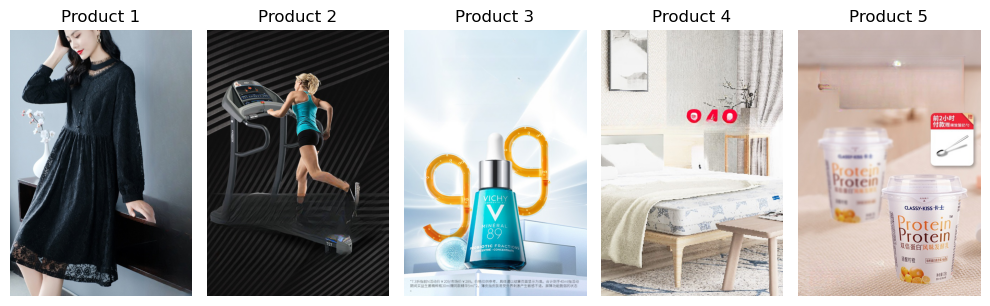

In [612]:
# Picking random samples from the dataset to display
#seelecting 5 indices randomly
random_indices = random.sample(range(len(dataset)), 5)
#Converting images to RGB
random_images = [dataset[i]['image'].convert("RGB") for i in random_indices]

#Displaying images
# Diving into 5 columns with each image size as 10 x 3
fig, axs = plt.subplots(1, 5, figsize=(10, 3))  # shorter height

for idx, (img, ax) in enumerate(zip(random_images, axs)):
    ax.imshow(img)
    ax.set_title(f"Product {idx+1}", fontsize=12)
    ax.axis("off")
plt.tight_layout()
plt.show()


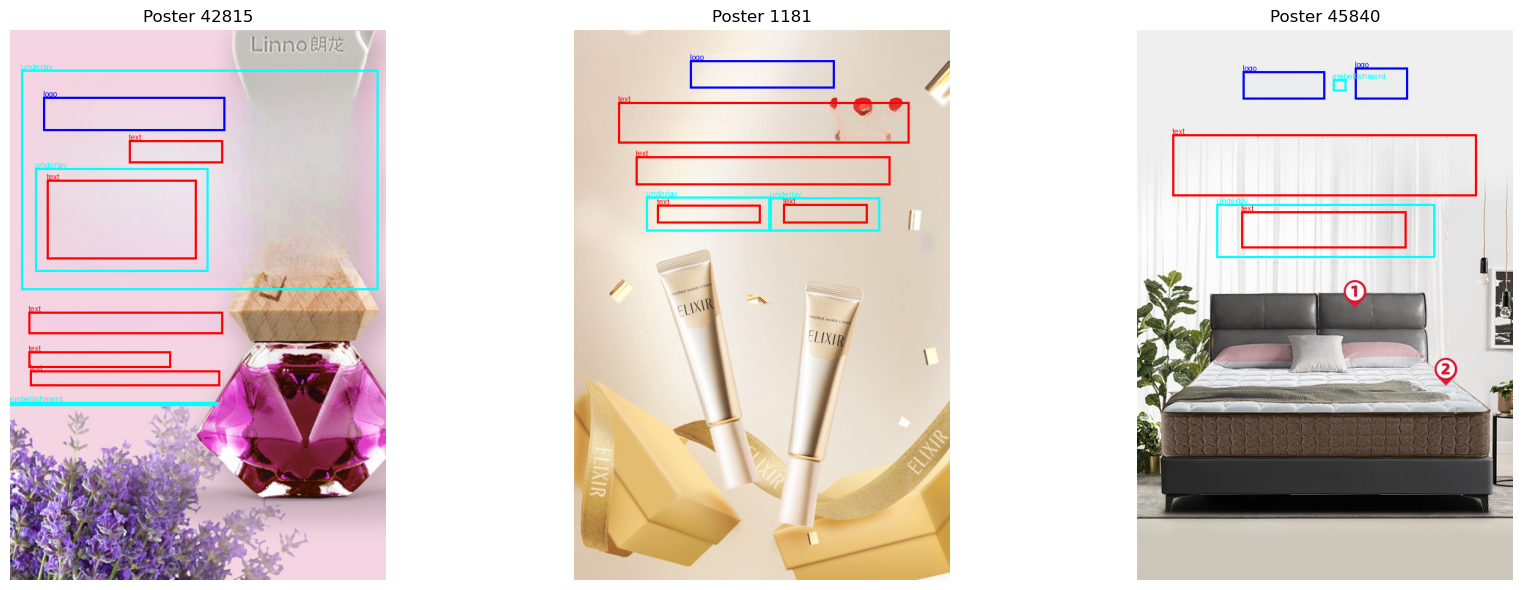

In [632]:
# Define colors for each category type
category_colors = {'text': 'red', 'logo': 'blue, 'image': 'green', 'price': 'yellow'}

# Selecting any 3 random samples
samples= random.sample(range(len(dataset)), 3)

# Displaying 3 images horizontally of size 18 x 6
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# implemnting a loop for all indices
for i, idx in enumerate(samples):
    # extracting data 
    sample = dataset[idx]
    # creating a copy to make changes
    img = sample['image'].copy()
    # Initialising the drawing canvas
    draw = ImageDraw.Draw(img)

    # Draw bounding boxes
    for bbox, cat in zip(sample['annotations']['bbox'], sample['annotations']['category']):
       # Defining the position of the box
        x, y, w, h = bbox
        #fetching the type of label
        label = cat.get('supercategory', 'unknown')
        #using colors defined above
        color = category_colors.get(label, 'cyan')
        #Drawing the rectangle for the bounding boxes
        draw.rectangle([x, y, x + w, y + h], outline=color, width=3)
    
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Poster {idx}")

plt.tight_layout()
plt.show()


In [244]:
# Taking subset of dataset for implementation
quick_subset = dataset.select(range(1000))  # Or 3000 even faster
random.seed(2)
# Taking random 50 enteries of subset dataset for implementation
subset = random.sample(get_text_bbox_samples(quick_subset),50)


In [698]:
#As the dataset is missing the product names and tone; defining for the first 50 
product_labels = [
    {"product_name": "She's YEA Beauty Mask Box", "tone": "Care"},
    {"product_name": "Beige Winter Coat", "tone": "Elegant"},
    {"product_name": "Dr.Yu Facial Mask Pack", "tone": "Soothing"},
    {"product_name": "Kids' Matching School Uniforms", "tone": "Cheerful"},
    {"product_name": "AR Shark Blaster Toy", "tone": "Playful"},
    {"product_name": "Slim Remote Controller", "tone": "Practical"},
    {"product_name": "Lavender Activewear Set", "tone": "Energetic"},
    {"product_name": "Green Jade Ring and Bracelet Set", "tone": "Fun"},
    {"product_name": "Tweed Contrast Winter Coat", "tone": "Stylish"},
    {"product_name": "PROYA Sunscreen Egg SPF 50", "tone": "Care"},
    {"product_name": "Rose Gold Electric Grill", "tone": "Fun"},
    {"product_name": "Industrial Deep Fryer", "tone": "Practical"},
    {"product_name": "White Smart Spray Mop", "tone": "Clean"},
    {"product_name": "ChuChu Baby Bottle & Veggie Wash", "tone": "Trustworthy"},
    {"product_name": "ADDICTION Skin Protector SPF 50", "tone": "Premium"},
    {"product_name": "Gunnar Sport Sunglasses", "tone": "Fun"},
    {"product_name": "Pressed Tea Cake (Pu'er)", "tone": "Traditional"},
    {"product_name": "Coffee Tasting / Training Scene (N/A)", "tone": "Fun"},
    {"product_name": "Decorté AQ Skincare Collection", "tone": "Luxury"},
    {"product_name": "Zen Aroma Reed Diffuser Set", "tone": "Luxury"},
    {"product_name": "HONOR Smartphone", "tone": "Futuristic"},
    {"product_name": "Sisley Black Rose Skin Infusion Cream", "tone": "Care"},
    {"product_name": "Luxury Lighter Set", "tone": "Safety"},
    {"product_name": "White Safety Helmet", "tone": "Safety"},
    {"product_name": "Cigarette Display Organizer", "tone": "Practical"},
    {"product_name": "Remote-Controlled Ceiling Light Set", "tone": "Modern / Tech-savvy"},
    {"product_name": "Dog Food Sausage Roll", "tone": "Playful / Friendly"},
    {"product_name": "Men’s Whitening Facial Cleanser", "tone": "Care"},
    {"product_name": "Smart Touchless Hand Sanitizer Dispenser", "tone": "tech-savvy"},
    {"product_name": "Car Paint Protection Film Kit", "tone": "Easy"},
    {"product_name": "Camel Milk Powder Formula", "tone": "Health-Conscious"},
    {"product_name": "Soft Comfort Body Pillow", "tone": "Cozy / Sleep-Focused"},
    {"product_name": "Woven Textured Rug", "tone": "Earthy"},
    {"product_name": "Kids' Vision Screener / Eye Examination Machine", "tone": "Educational"},
    {"product_name": "Premium Fashion Retail Space", "tone": "Sleek / Minimalist / Modern"},
    {"product_name": "Pearl-Inspired Eyeshadow Palette", "tone": "Pretty"},
    {"product_name": "Freeplus Moist Care Skincare Set", "tone": "Gentle"},
    {"product_name": "Traditional Wooden Tea Table Set", "tone": "Minimalist Zen"},
    {"product_name": "Traditional Japanese Waitress Uniform", "tone": "Work"},
    {"product_name": "Adjustable Baby Car Seat", "tone": "Protective"},
    {"product_name": "Horizontal Deep Freezer", "tone": "Tech-savvy"},
    {"product_name": "Minimalist Shower Curtain", "tone": "Functional"},
    {"product_name": "Camellia Radiant Skincare Set", "tone": "Gentle"},
    {"product_name": "Vertical Water Rowing Machine", "tone": "Energetic/ Wellness-Focused"},
    {"product_name": "Hydrating Lip Balm", "tone": "Feminine"},
    {"product_name": "Helena Rubinstein Pure Ritual Cleanser Set", "tone": "soothing"},
    {"product_name": "Albion Skin Conditioner Essential Lotion", "tone": "Clean / gentle"},
    {"product_name": "The Glenlivet Founder’s Reserve Single Malt Scotch Whisky", "tone": "Elegant / fun"},
    {"product_name": "VR Headset with Motion Controllers", "tone": "Futuristic / Tech-savvy"},
    {"product_name": "Wired Gaming Controller", "tone": "Energetic / Gamer-friendly"}
]


In [700]:
# Adding to dataset ;above 2 columns defined
for i, entry in enumerate(subset):
    entry["product_name"] = product_labels[i]["product_name"]
    entry["tone"] = product_labels[i]["tone"]

# Converting to DataFrame
subset_df = pd.DataFrame(subset)
subset_df.head()


,image_id,file_name,width,height,image,annotations,text_annotations,text_features,product_name,tone
0,1615,O1CN01qdMwDO1dnHpoXgZBu_!!4020843780-0-alimama...,513,750,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"{'annotation_id': [4939, 4940, 4941, 4942, 494...",None,None,She's YEA Beauty Mask Box,Care
1,1464,O1CN01hXz2vS1N3ukTPkMA3_!!276811515-0-alimamaz...,513,750,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"{'annotation_id': [4478, 4479, 4480, 4481, 448...","{'is_sample': False, 'image': 'ali_anno_1/884....","{'num': 3, 'pos': [[126, 438, 262, 47], [124, ...",Beige Winter Coat,Elegant
2,1600,O1CN0170fY7v2G3H47WfArC_!!1975328959-0-alimama...,513,750,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"{'annotation_id': [4899, 4900, 4901, 4902, 490...","{'is_sample': False, 'image': 'ali_anno_1/972....","{'num': 3, 'pos': [[42, 104, 430, 65], [106, 1...",Dr.Yu Facial Mask Pack,Soothing
3,1444,O1CN01TRcVCK29WOvFwHIZP_!!1662038075-0-alimama...,513,750,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"{'annotation_id': [4418, 4419, 4420, 4421, 442...",None,None,Kids' Matching School Uniforms,Cheerful
4,92,O1CN019GuNly272yGUMY0Le_!!875117740-0-alimamaz...,513,750,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"{'annotation_id': [287, 288, 289, 290], 'area'...","{'is_sample': False, 'image': 'ali_anno_1/57.p...","{'num': 2, 'pos': [[56, 85, 404, 59], [194, 16...",AR Shark Blaster Toy,Playful


In [702]:
# Using the above slogan generate function to generate slogans for all rows in subset_df
subset_df["slogan"] = subset_df.apply(
    lambda row: generate_slogan(row["product_name"], row["tone"]),
    axis=1
)



 The slogan generated by LLM for: She's YEA Beauty Mask Box | and specified Tone: Care

 🧠 Generated Slogans (3 for each) 
1. Nurture your skin with She's YEA Beauty Mask Box
2. Unwrap self-care with She's YEA Beauty Mask Box
3. Transform your routine with She's YEA Beauty Mask Box

 Best Slogan: Nurture your skin with She's YEA Beauty Mask Box
 --------------------------------------------------------------------------------------------------------------------- 

 The slogan generated by LLM for: Beige Winter Coat | and specified Tone: Elegant

 🧠 Generated Slogans (3 for each) 
1. "Elegance in Every Snowflake"
2. "Wrap Yourself in Timeless Chic"
3. "Where Winter Meets Sophistication"

 Best Slogan: "Wrap Yourself in Timeless Chic"
 --------------------------------------------------------------------------------------------------------------------- 

 The slogan generated by LLM for: Dr.Yu Facial Mask Pack | and specified Tone: Soothing

 🧠 Generated Slogans (3 for each) 
1. Unwind wi

# Slogan Rendering Module

In [986]:
def get_largest_box(boxes):
    #Fetches the largest box by area from multiple annotations, to place the slogan in the largest box
    largest_box = max(boxes, key=lambda b: b[2] * b[3]) 
    return  largest_box if boxes else None


In [988]:
def get_contrast_text_color(crop_region):
    # calculating the brightness of a region and deciding text color based on it
    # black if background region is bright
    # white if background region is dark
    avg_color = np.array(crop_region).mean(axis=(0, 1))  # RGB mean
    brightness = np.dot(avg_color, [0.299, 0.587, 0.114])  # luminance
    if brightness > 180 
        return (0, 0, 0)  #bright
    else 
    return (255, 255, 255) #dark


In [ ]:
def draw_text_with_shadow(draw, position, text, font, fill, shadow_color=(0, 0, 0)):
    # this draws the text with a shadow effect
    # effect should be of 1 pixel towards right diagnolly
    shadow_offset = 1
    #fetches the x and y coordinates
    x, y = position
    #draws the shadow
    draw.text((x + shadow_offset, y + shadow_offset), text, font=font, fill=shadow_color)
    #draws the text
    draw.text((x, y), text, font=font, fill=fill)


In [1018]:
def draw_slogan_clean_split(image, slogan, box, font_path="arialbd.ttf"):
    """
    Placing the generated slogan as two lines into the given bounding box on the image.
    - Splits the slogan in half
    - Resizes font to fit box width
    - Aligning text centre
    - Chooses black or white text based on background brightness
    - Draws the text with a shadow effect
    """

    # Get background colour to determine text color
    # fetching the box dimensions
    x, y, w, h = box
    # Calculating the padding of the cell
    padding = int(0.08 * h)
    draw = ImageDraw.Draw(image)
    # For computing the brightness, we are cropping the region where text would be placed
    cropped_region = image.crop((x, y, x + w, y + h))
    #using the above defined function to choose black or white as color
    text_color = get_contrast_text_color(cropped_region)

    # Loading fonts
    try:
        font_primary = ImageFont.truetype("DejaVuSans-Bold.ttf", size=10) #first line as bold
        font_secondary = ImageFont.truetype("DejaVuSans.ttf", size=10) # second line normal weight
    except:
        #system default
        font_primary = font_secondary = ImageFont.load_default()

    # Splitting the generated slogan into words
    words = slogan.strip().split()
    #calculating centre of slogan
    split_point = len(words) // 2
    # first half
    primary = " ".join(words[:split_point])
    #second half
    secondary = " ".join(words[split_point:]) if len(words) > split_point else None

    #Setting the size of the font based on the available space
    # setting first line as larger
    max_font_primary = min(int((h - 2 * padding) * 0.45), 42)
    # setting second line as smaller
    max_font_secondary = min(int((h - 2 * padding) * 0.3), 28)
    min_font = 12

    # Fixing the font sizes by decreasing them 
    #stopping condition: until both lines fit in the width
    for fs in range(max_font_primary, min_font, -1):

        # current font size
        font_primary = ImageFont.truetype(font_path, fs)
        if secondary:
            font_secondary = ImageFont.truetype(font_path, max_font_secondary)


        tw1, th1 = draw.textbbox((0, 0), primary, font=font_primary)[2:]
        tw2, th2 = draw.textbbox((0, 0), secondary, font=font_secondary)[2:] if secondary else (0, 0)

        # If both lines fit within the box width (after padding), break the loop
        if max(tw1, tw2) <= (w - 2 * padding):
            break

    # Calculating value to place text at center
    total_height = th1 + (th2 + 5 if secondary else 0)
    ty = y + (h - total_height) // 2
    tx1 = x + (w - tw1) // 2
    tx2 = x + (w - tw2) // 2 if secondary else 0

    # Draw text with a shadow effect
    draw_text_with_shadow(draw, (tx1, ty), primary, font_primary, text_color)
    if secondary:
        draw_text_with_shadow(draw, (tx2, ty + th1 + 5), secondary, font_secondary, text_color)

    # Pass the modified image
    return image


In [1020]:
# Filter the samples that have at least 1 text bounding box

valid_samples_all = []
# looping through all rows
for _, row in subset_df.iterrows():
    #fetching text_fetaures column
    tf = row.get("text_features", {})
    
    # if it is a string , conver to a dict
    if isinstance(tf, str):
        try:
            tf = ast.literal_eval(tf)
        # if parse fails, empty dict
        except:
            tf = {}

    # valid annotation if 'pos' key exists and is a non-empty list
    if isinstance(tf, dict) and isinstance(tf.get("pos", []), list) and tf["pos"]:
        valid_samples_all.append(row)

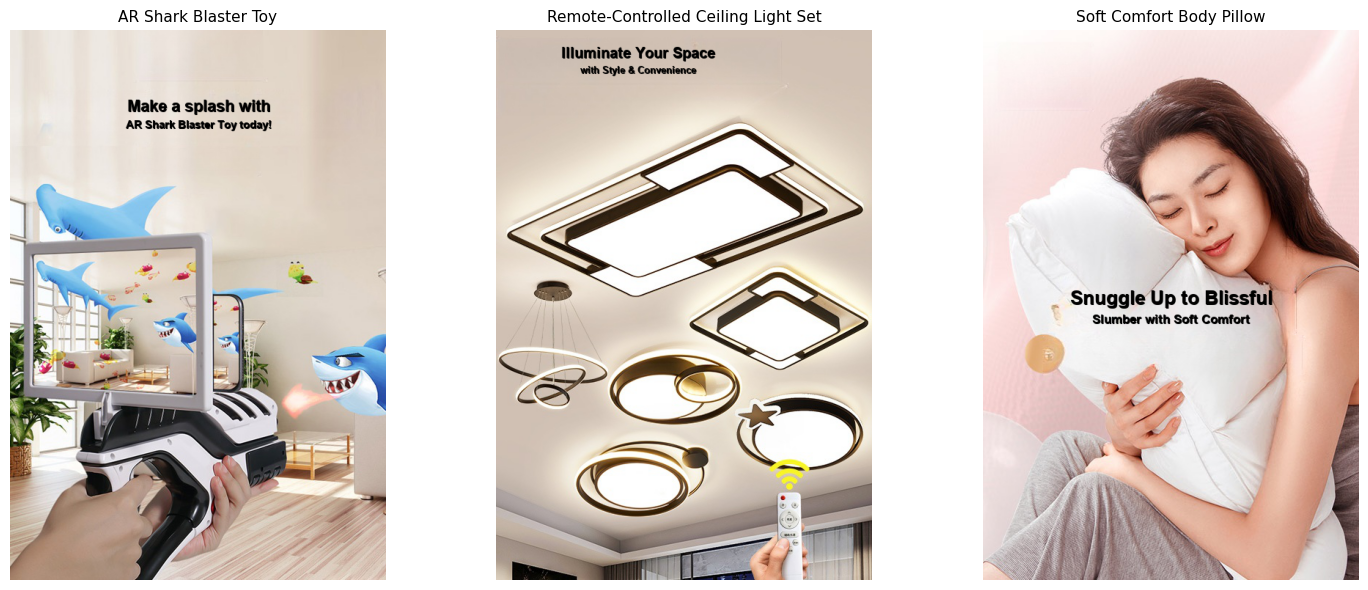

In [1022]:
# Displaying the images, on every run it will show any 3 random images

# Randomly selecting any 3 valid samples
valid_samples = random.sample(valid_samples_all, 3)

# Setup to plot the selected posters side by side 
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Looping through all the samples 
for ax, sample in zip(axs, valid_samples):
    # copying the image
    image = sample["image"].copy()
    # fetching the slogan
    slogan = sample["slogan"]
    # fetching the product name
    product_name = sample["product_name"]

    # Parse text_features
    tf = sample.get("text_features", {})
    if isinstance(tf, str):
        try:
            tf = ast.literal_eval(tf)
        except:
            tf = {}

    boxes = tf.get("pos", [])

    # fetches the list of bounding boxes
    if isinstance(boxes, list) and boxes:
        # finding the biggest box by area
        largest_box = get_largest_box(boxes)
        # add the slogan inside the largest box
        poster_img = draw_slogan_clean_split(image, slogan, largest_box)
        ax.imshow(poster_img)
        ax.set_title(product_name, fontsize=11)
        ax.axis("off")

plt.tight_layout()
plt.show()


# Banner Generation Module

In [1067]:
# Deciding the background colour for the CTA part based on brightness

def get_contrast_background_color(crop_region):
    crop_region = crop_region.convert("RGB")  
    avg_color = np.array(crop_region).mean(axis=(0, 1))
    brightness = np.dot(avg_color, [0.299, 0.587, 0.114])
    if brightness > 180:
        bg_color = (20, 20, 20) #light gray
    else: 
        bg_color =  (245, 245, 245) #black
    return bg_color

In [1069]:
# Deciding the text colour based on brightness

def get_contrast_text_color(crop_region):
    np_region = np.array(crop_region)

    # if the region extracted is in grayscale (2D), we will convert it to RGB 
    if np_region.ndim == 2:
        np_region = np.stack([np_region]*3, axis=-1) 

    avg_color = np_region.mean(axis=(0, 1)) 
    brightness = float(np.dot(avg_color, [0.299, 0.587, 0.114]))
    if brightness > 180:
        text_color = (0, 0, 0)    
    else: 
        text_color = (255, 255, 255)
    return text_color


In [1075]:
# Composing the final poster by adding the CTA banner

def compose_final_poster(base_image, cta_text="Buy Now", price=None):
    #converting to gdb(3D) channel
    image = base_image.convert("RGBA")
    width, height = image.size

    #Increasing the size of image by 25%
    canvas_height = height + int(0.25 * height)
    new_img = Image.new("RGBA", (width, canvas_height), (255, 255, 255, 0))
    new_img.paste(image, (0, 0))
    draw = ImageDraw.Draw(new_img)

    # To decide the colour of the CTA background: extracting from bottom of image
    sample_strip = image.crop((0, int(height * 0.85), width, height))
    #fetching the background colour
    cta_bg_color = get_contrast_background_color(sample_strip)
    # Compute text color based on background brightness
    brightness = np.dot(cta_bg_color, [0.299, 0.587, 0.114])
    if brightness > 180:
        text_color =  (0, 0, 0) 
    else:
        text_color=(255, 255, 255)
    text_color = text_color

    # Drawing the background for CTA 
    cta_y_start = height
    draw.rectangle([(0, cta_y_start), (width, canvas_height)], fill=cta_bg_color)

    # Load fonts
    try:
        font_cta = ImageFont.truetype("arial.ttf", 28)
        font_price = ImageFont.truetype("arialbd.ttf", 40) #setting bold
        font_tag = ImageFont.truetype("arial.ttf", 28)
    except:
        #setting default font style
        font_cta = font_price = font_tag = ImageFont.load_default()

    # Publishing any random price between 15 to 50
    price = price or f"${random.randint(15, 49)}.{random.randint(10, 99)} AUD"
    tagline = "Hurry Up! Limited Time Only"
    center_x = width // 2

    # Adding the CTA Button 
    #setting round rectangle shape
    btn_w, btn_h = draw.textbbox((0, 0), cta_text, font=font_cta)[2:]
    btn_x1 = center_x - btn_w // 2 - 40
    btn_x2 = center_x + btn_w // 2 + 40
    btn_y1 = cta_y_start + 20
    btn_y2 = btn_y1 + btn_h + 30
    draw.rounded_rectangle([btn_x1, btn_y1, btn_x2, btn_y2], fill=text_color, radius=20)
    draw.text((center_x - btn_w // 2, btn_y1 + 15), cta_text, font=font_cta, fill=cta_bg_color)

    # Adding price
    price_w, price_h = draw.textbbox((0, 0), price, font=font_price)[2:]
    price_y = btn_y2 + 20
    draw.text((center_x - price_w // 2, price_y), price, font=font_price, fill=text_color)

    # Adding the tagline
    tag_w, tag_h = draw.textbbox((0, 0), tagline, font=font_tag)[2:]
    tag_y = price_y + tag_h + 10
    draw.text((center_x - tag_w // 2, tag_y), tagline, font=font_tag, fill=text_color)

    return new_img.convert("RGB")


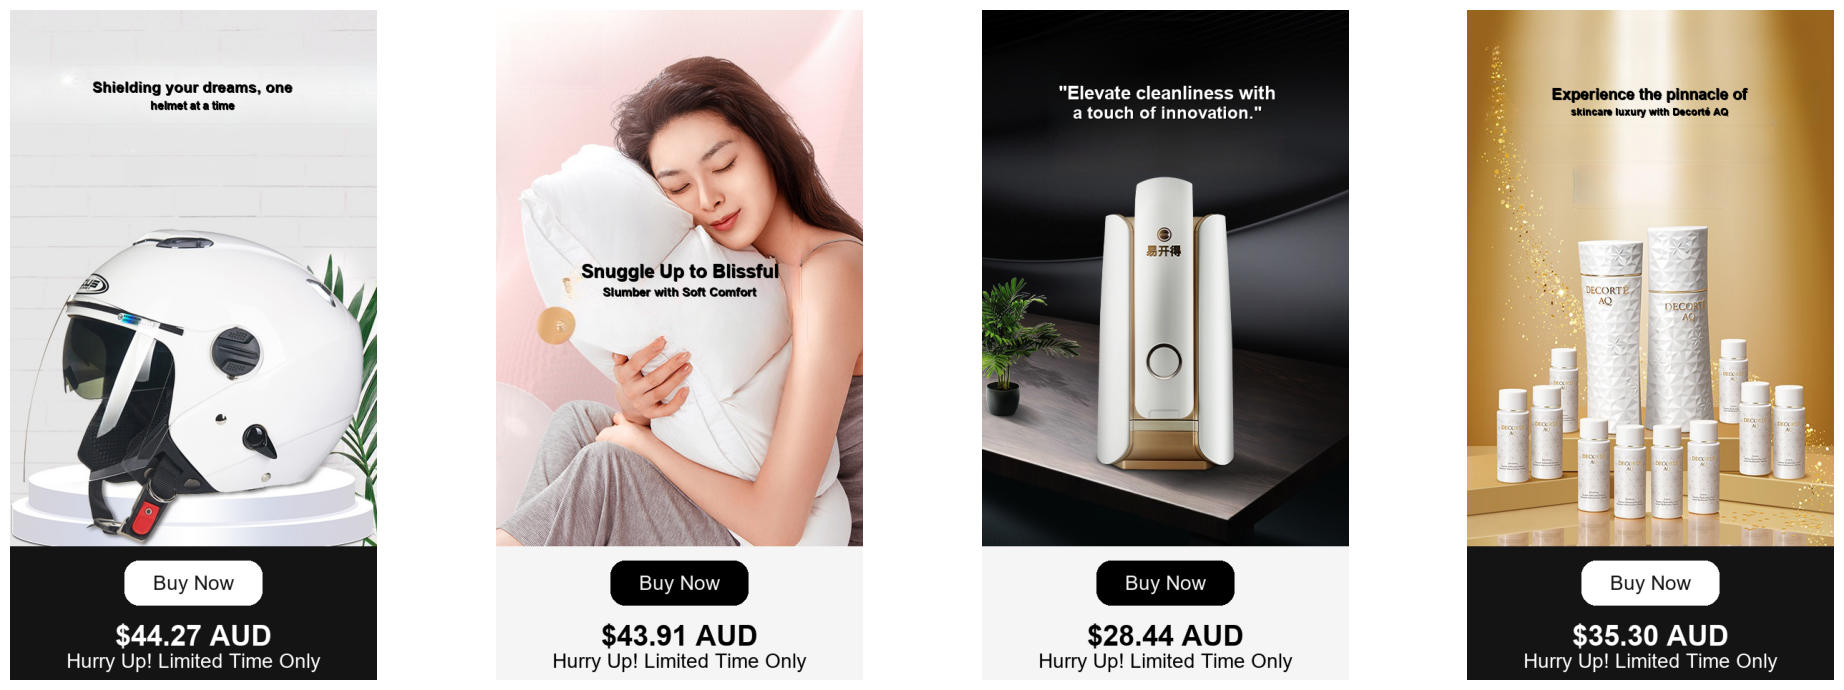

In [1081]:
# Select any 5 random images from the dataframe
images_to_plot = []
random_indices = random.sample(range(len(subset_df)), 5)

#For each randomly selected image:
for i in random_indices:
    # Extract the row with all details
    sample = subset_df.iloc[i]
    # making a copy of the image
    image = sample["image"].copy()
    #fetch the slogan generated by LLM
    slogan = sample["slogan"]

    # Parse the bounding box - text_column
    tf = sample.get("text_features", {})
    if isinstance(tf, str):
        try:
            # Converting from string to dict
            tf = ast.literal_eval(tf)
        except:
            #empty dict
            tf = {}
    elif not isinstance(tf, dict):
        tf = {}

    # Extracting the bounding boxes list
    boxes = tf.get("pos", [])
    if isinstance(boxes, list) and boxes:
        # placing the slogan in the largest box
        largest_box = get_largest_box(boxes)
        result = draw_slogan_clean_split(image, slogan, largest_box)
        #adding the CTA part
        final_poster = compose_final_poster(result, cta_text="Buy Now")
        #Save 
        images_to_plot.append(final_poster)

# Plotting all randomly selected posters
fig, axs = plt.subplots(1, len(images_to_plot), figsize=(5 * len(images_to_plot), 7))

if len(images_to_plot) == 1:
    axs = [axs]

for ax, img in zip(axs, images_to_plot):
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()
